In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

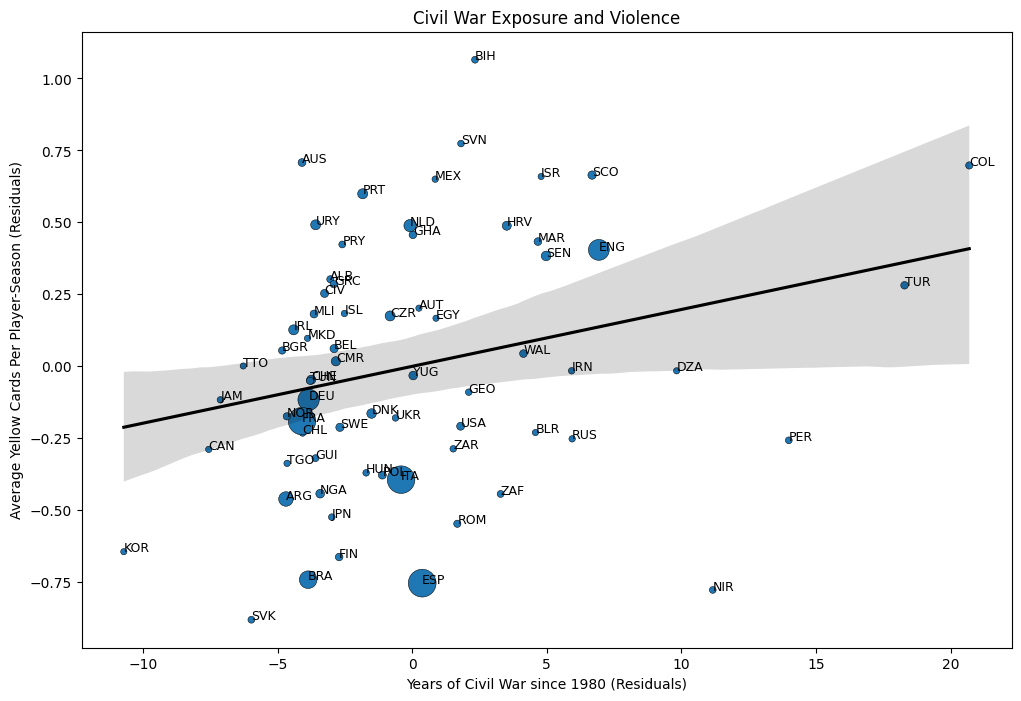

In [27]:
# Load data
wb_codes = pd.read_csv("Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")
soccer_data = pd.read_stata("soccer_data.dta")

# drop num_country and missing contract
soccer_data = soccer_data.drop(columns=["num_country"])
soccer_data = soccer_data.dropna(subset=["contract"])

# only keep these leagues
top_leagues = ['italian', 'champions', 'english', 'french', 'german', 'spanish']
soccer_data['league'] = soccer_data[top_leagues].any(axis=1)

# get the number of players per country
league_counts = soccer_data[soccer_data['league']].groupby('nationality')['player_id'].count()
soccer_data['num_country'] = soccer_data['nationality'].map(league_counts)

# merge wb_codes
soccer_data = soccer_data.merge(wb_codes, how="left", on="nation")

# Collapse

collapsed = ['wb_code', 'yellow_card', 'civwar', 'nation', 'num_country', 'age',
             'games_start', 'games_sub', 'goalie', 'defender',
 'forward', 'midfield', 'goals', 'ln_contract', 
 'italian', 'champions', 'english', 'french', 'german', 'spanish',
    'africa', 'asia', 'lac', 'east_europe', 'oecd']

collapse_df = soccer_data[soccer_data['league'] & (soccer_data['num_country'] >= 5)]
collapse_df = collapse_df[collapsed].groupby('wb_code').mean().reset_index()


# regress for yellow_card
vars1 = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
# making the regfression model
X1 = collapse_df[vars1]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()


collapse_df['yellow_hat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellow_hat']


# regress for civwar
# making the regression model
y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()


collapse_df['war_hat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['war_hat']


# scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

# labelinfg points for each country
for i, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("Civil War Exposure and Violence");

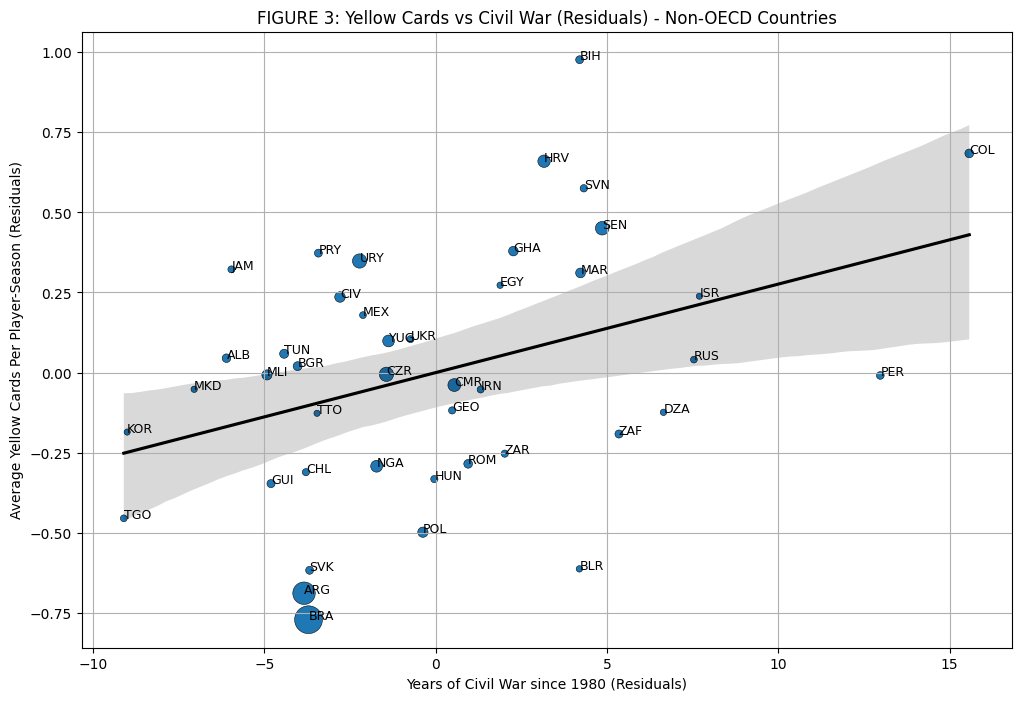

In [28]:
# LOADING DATA
wb_codes = pd.read_csv("Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")
soccer = pd.read_stata("soccer_data.dta")

# CLEANING AND FILTERING DATA
soccer = soccer.dropna(subset=["contract"])

# RELEVANT COUNTRIES: FROM "if (italian | champions |  english  | french | german | spanish)"
country_cols = ['italian', 'champions', 'english', 'french', 'german', 'spanish']
soccer['country_flag'] = soccer[country_cols].any(axis=1)

# PLAYER COUNT BY NATIONALITY
soccer['player_id'] = soccer['player_id'].astype(str)
soccer['num_country'] = soccer.groupby('nationality')['player_id'].transform(
    lambda x: x.count() if soccer.loc[x.index, 'country_flag'].any() else np.nan
)

soccer = soccer[soccer['oecd'] == 0]

soccer = soccer.merge(wb_codes, how="left", on="nation")

# GROUP SELECTED COLUMNS BY wb_code AND AGGREGATE BY MEAN
group_vars = [
    'wb_code', 'nation', 'civwar', 'age', 'games_start', 'games_sub',
    'goalie', 'defender', 'forward', 'midfield', 'goals', 'ln_contract'
] + country_cols + ['africa', 'asia', 'lac', 'east_europe', 'oecd', 'yellow_card', 'num_country']

collapse_df = soccer[soccer['country_flag'] & (soccer['num_country'] >= 5)]
collapse_df = collapse_df[group_vars].groupby('wb_code').mean().reset_index()

# FIRST REGRESSION: BY YELLOW CARD
X1_vars = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
X1 = collapse_df[X1_vars]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()
collapse_df['yellowhat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellowhat']

# SECOND REGRESSION: BY CIVIL WAR 
y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()
collapse_df['warhat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['warhat']

# PLOTTING
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

for i, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("FIGURE 3: Yellow Cards vs Civil War (Residuals) - Non-OECD Countries")
plt.grid(True)
plt.show()

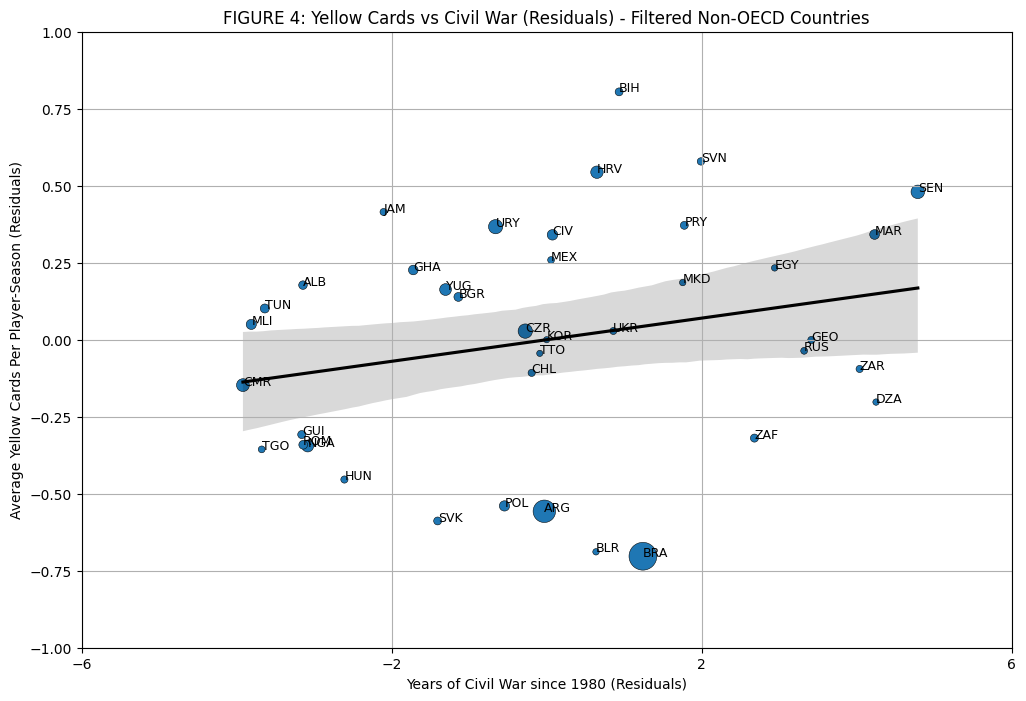

In [29]:

wb_codes = pd.read_csv("Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")

#Load soccer and clean
soccer = pd.read_stata("soccer_data.dta")
soccer = soccer.dropna(subset=["contract"])
soccer['country_flag'] = soccer[['italian', 'champions', 'english', 'french', 'german', 'spanish']].any(axis=1)
soccer['player_id'] = soccer['player_id'].astype(str)
soccer['num_country'] = soccer.groupby('nationality')['player_id'].transform(
    lambda x: x.count() if soccer.loc[x.index, 'country_flag'].any() else np.nan
)
soccer = soccer[soccer['oecd'] == 0]
nations_drop = [23, 52, 54, 78, 101]
soccer = soccer[~soccer['nation'].isin(nations_drop)]

soccer = soccer.merge(wb_codes, how="left", on="nation")

group_vars = [
    'wb_code', 'nation', 'civwar', 'age', 'games_start', 'games_sub',
    'goalie', 'defender', 'forward', 'midfield', 'goals', 'ln_contract'
] + country_cols + ['africa', 'asia', 'lac', 'east_europe', 'oecd', 'yellow_card', 'num_country']

collapse_df = soccer[soccer['country_flag'] & (soccer['num_country'] >= 5)]
collapse_df = collapse_df[group_vars].groupby('wb_code').mean().reset_index()


#Regress
X1_vars = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
X1 = collapse_df[X1_vars]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()
collapse_df['yellowhat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellowhat']

y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()
collapse_df['warhat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['warhat']

#PLOTTTTT
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

for _, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("FIGURE 4: Yellow Cards vs Civil War (Residuals) - Filtered Non-OECD Countries")
plt.xticks(np.arange(-6, 7, 4))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.grid(True)
plt.show()


In [30]:
figure_1a = pd.read_excel('graphs/Figure_1A.xls').dropna()
figure_1a = figure_1a[figure_1a['cause'] != 'Total']
figure_1a


,League,cause,2005-2006,2006-2007,2007-2008,Average,Percent
0,Serie A TIM,Assault,1299,1357.0,1413.0,1356.333333,73.834150
1,Serie A TIM,Unsportsmanlike Conduct,207,320.0,281.0,269.333333,14.661586
2,Serie A TIM,Other Non-Violent,174,235.0,225.0,211.333333,11.504264


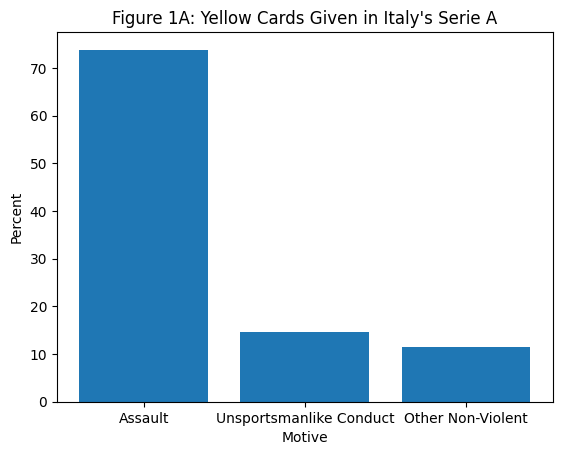

In [31]:
plt.bar(figure_1a['cause'], figure_1a['Percent'])
plt.xlabel('Motive')
plt.ylabel('Percent')
plt.title("Figure 1A: Yellow Cards Given in Italy's Serie A")
plt.show()

In [32]:
figure_1b = pd.read_excel('graphs/Figure_1B.xls')
figure_1b = figure_1b[figure_1b['Motive'] != 'Grand Total']
figure_1b

,Motive,2004-2005,2005-2006,Sum,Percent
0,Violent Foul,446,464,910,64.447592
1,Unsporting Behavior,177,193,370,26.203966
2,Non-Violent Offense,56,76,132,9.348442


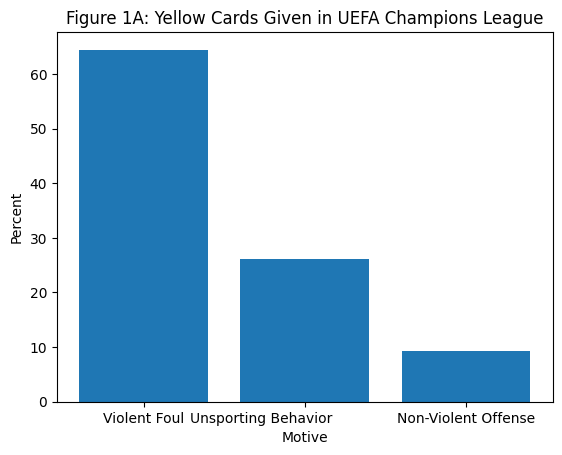

In [33]:
plt.bar(figure_1b['Motive'], figure_1b['Percent'])
plt.xlabel('Motive')
plt.ylabel('Percent')
plt.title("Figure 1A: Yellow Cards Given in UEFA Champions League")
plt.show()

In [34]:
soccer

,player_id,player_name,war_before,war_after,year,team,nationality,position,age,league,...,contract,asia,lac,income,ln_wage,ln_contract,num_country,ln_income,country_flag,wb_code
0,2726,Nelson de Jesus Dida,0.0,0.0,2004/05 Statistics,AC Milan,Brazil,G,31,UEFA Champions League,...,14000000.0,0,1,8800.0,10.043249,16.454567,277,9.082507,True,BRA
1,2726,Nelson de Jesus Dida,0.0,0.0,2004/05 Statistics,AC Milan,Brazil,G,31,Italian Serie A,...,14000000.0,0,1,8800.0,10.043249,16.454567,277,9.082507,True,BRA
2,2741,Juliano Belletti,0.0,0.0,2004/05 Statistics,Barcelona,Brazil,D,28,Spanish Primera DivisiÛn,...,8600000.0,0,1,8800.0,10.778956,15.967273,277,9.082507,True,BRA
3,2741,Juliano Belletti,0.0,0.0,2004/05 Statistics,Barcelona,Brazil,D,28,UEFA Champions League,...,8600000.0,0,1,8800.0,10.778956,15.967273,277,9.082507,True,BRA
4,2749,Cris,0.0,0.0,2004/05 Statistics,Lyon,Brazil,D,27,French Ligue 1,...,4600000.0,0,1,8800.0,10.545341,15.341567,277,9.082507,True,BRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,85191,Jiri Stajner,0.0,0.0,2005/06 Statistics,Hannover 96,Czech Republic,F,28,German Bundesliga,...,5250000.0,0,0,21470.0,10.257659,15.473739,67,9.974412,True,CZR
1322,85195,Altin Lala,0.0,0.0,2005/06 Statistics,Hannover 96,Albania,M,29,German Bundesliga,...,4900000.0,0,0,5840.0,10.571317,15.404746,18,8.672486,True,ALB
1323,85454,Vinicius,0.0,0.0,2005/06 Statistics,Hannover 96,Brazil,D,24,German Bundesliga,...,3000000.0,0,1,8800.0,9.952278,14.914123,277,9.082507,True,BRA
1324,86063,Fatmir Vata,0.0,0.0,2005/06 Statistics,Arminia Bielefeld,Albania,M,33,German Bundesliga,...,2100000.0,0,0,5840.0,10.448714,14.557447,18,8.672486,True,ALB
